In [0]:
import os
import csv
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving driving_log.csv to driving_log.csv


In [0]:
lines = []

with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)

In [5]:
data = pd.read_csv('driving_log.csv')
data.head()

,F:\Udacity Simulator\Training-data\IMG\center_2019_12_03_21_13_32_942.jpg,F:\Udacity Simulator\Training-data\IMG\left_2019_12_03_21_13_32_942.jpg,F:\Udacity Simulator\Training-data\IMG\right_2019_12_03_21_13_32_942.jpg,0,0.1,0.2,11.95879
0,F:\Udacity Simulator\Training-data\IMG\center_...,F:\Udacity Simulator\Training-data\IMG\left_20...,F:\Udacity Simulator\Training-data\IMG\right_2...,0.0,0.107378,0.0,11.65876
1,F:\Udacity Simulator\Training-data\IMG\center_...,F:\Udacity Simulator\Training-data\IMG\left_20...,F:\Udacity Simulator\Training-data\IMG\right_2...,0.0,0.338153,0.0,11.90341
2,F:\Udacity Simulator\Training-data\IMG\center_...,F:\Udacity Simulator\Training-data\IMG\left_20...,F:\Udacity Simulator\Training-data\IMG\right_2...,0.0,0.535286,0.0,12.18276
3,F:\Udacity Simulator\Training-data\IMG\center_...,F:\Udacity Simulator\Training-data\IMG\left_20...,F:\Udacity Simulator\Training-data\IMG\right_2...,0.0,0.765195,0.0,12.68862
4,F:\Udacity Simulator\Training-data\IMG\center_...,F:\Udacity Simulator\Training-data\IMG\left_20...,F:\Udacity Simulator\Training-data\IMG\right_2...,0.0,0.939946,0.0,13.11198


In [6]:
data.shape

(6209, 7)

In [7]:
lines[0]

['F:\\Udacity Simulator\\Training-data\\IMG\\center_2019_12_03_21_13_33_012.jpg',
 'F:\\Udacity Simulator\\Training-data\\IMG\\left_2019_12_03_21_13_33_012.jpg',
 'F:\\Udacity Simulator\\Training-data\\IMG\\right_2019_12_03_21_13_33_012.jpg',
 '0',
 '0.1073775',
 '0',
 '11.65876']

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
import os
os.chdir("/content/drive/My Drive/car_drive_data")
!ls

IMG.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/car_drive_data/IMG.zip", 'r') 
zip_ref.extractall("IMG") 
zip_ref.close()

In [18]:
os.getcwd()

'/content/drive/My Drive/car_drive_data/IMG/IMG'

In [0]:
images = []
measurements = []
for line in lines:
    centre_path = "/content/drive/My Drive/car_drive_data/IMG/IMG/" + line[0].split('\\')[-1]
    left_path = "/content/drive/My Drive/car_drive_data/IMG/IMG/" + line[1].split('\\')[-1]
    right_path = "/content/drive/My Drive/car_drive_data/IMG/IMG/" + line[2].split('\\')[-1]
    
    image_centre =  io.imread(centre_path)

    image_left =  io.imread(left_path)
    #image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)

    image_right = io.imread(right_path)
    #image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB)

    correction = 0.2

    images.append(image_left)
    measurements.append(float(line[3]) + correction)

    images.append(image_right)
    measurements.append(float(line[3]) - correction)
    
    images.append(image_centre)
    
    measurement = float(line[3])
    measurements.append(measurement)

In [0]:
# data augmentation
aug_images, aug_measurements = [], []
for image, measurement in zip(images, measurements):
    aug_images.append(image)
    aug_measurements.append(measurement)
    aug_images.append(np.fliplr(image)) # this rotates the image
    aug_measurements.append(measurement*-1.0) # gives the measurement a opposite value now

In [0]:
X_train = np.array(aug_images)
y_train = np.array(aug_measurements)

In [22]:
X_train.shape

(37254, 160, 320, 3)

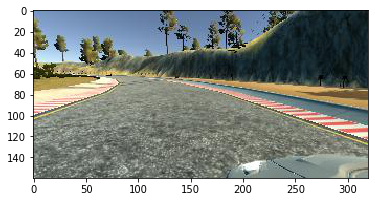

In [23]:
plt.imshow(X_train[0])
plt.show()

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers import Lambda, Cropping2D

model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# trim image to only see section with road
model.add(Cropping2D(cropping=((70,25),(0,0))))           

#layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Conv2D(24, (5, 5), strides = (2,2), activation = "relu"))

#layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Conv2D(36, ( 5,5), strides=(2,2), activation= "relu"))

#layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Conv2D(48, (5, 5), strides=(2,2), activation= "relu"))

#layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3) , activation= "relu"))

#layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3), activation= "relu"))

#flatten image from 2D to side by side
model.add(Flatten())

#layer 6- fully connected layer 1
model.add(Dense(100, activation= "relu"))

#Adding a dropout layer to avoid overfitting. Here we are have given the dropout rate as 25% after first fully connected layer
model.add(Dropout(rate=0.25))

#layer 7- fully connected layer 1
model.add(Dense(50, activation= "relu"))


#layer 8- fully connected layer 1
model.add(Dense(10, activation= "relu"))

#layer 9- fully connected layer 1
model.add(Dense(1)) #here the final layer will contain one value as this is a regression problem and not classification


# the output is the steering angle , i.e regression, now using adam optimizer and  using mean squared error loss function
model.compile(loss='mse',optimizer='adam')

In [26]:
# training the model
# epoch = 10 , batch_size = 32
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split=0.2, verbose= 1, shuffle= True)




Train on 29803 samples, validate on 7451 samples
Epoch 1/10





29803/29803 [==============================] - 379s 13ms/step - loss: 0.0484 - val_loss: 0.0423
Epoch 2/10
29803/29803 [==============================] - 387s 13ms/step - loss: 0.0367 - val_loss: 0.0356
Epoch 3/10
29803/29803 [==============================] - 398s 13ms/step - loss: 0.0316 - val_loss: 0.0376
Epoch 4/10
29803/29803 [==============================] - 394s 13ms/step - loss: 0.0283 - val_loss: 0.0403
Epoch 5/10
29803/29803 [==============================] - 390s 13ms/step - loss: 0.0265 - val_loss: 0.0379
Epoch 6/10
29803/29803 [==============================] - 389s 13ms/step - loss: 0.0242 - val_loss: 0.0445
Epoch 7/10
29803/29803 [==============================] - 372s 12ms/step - loss: 0.0226 - val_loss: 0.0416
Epoch 8/10
29803/29803 [==============================] - 369s 12ms/step - loss: 0.0212 - val_loss: 0.0454
Epoch 9/10
29803/29803 [==============================] - 363s 12ms/step - loss: 0.0196

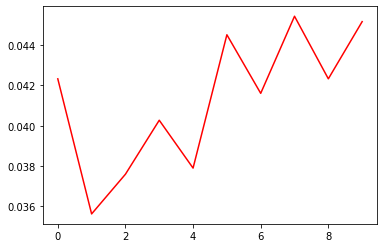

In [32]:
plt.plot(history.history['val_loss'], 'r')

In [28]:
#saving model
model.save('model.h5')

print('Model Saved')

# keras method to print the model summary
model.summary()

Model Saved
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 33,

In [0]:
from google.colab import files
files.download("/content/drive/My Drive/car_drive_data/IMG/IMG/model.h5")